# 가장 비슷한 이미지 템플릿 추천
---
문제 정의: 수많은 비슷한 이미지 템플릿 중에서 특정 이미지 템플릿과 가장 유사한 템플릿을 이유와 함께 선택하여 찾아 추천합니다.

## 실험 환경
- 이 노트북은 SageMaker Studio Code Editor 및 커널 base (Python 3.10.13) 에서 테스트 되었습니다.
- 실행 환경에 설치된 Python Package 참고 하세요. --> [requirements.txt](../requirements.txt)

## 참고 자료
- [Building with Anthropic’s Claude 3 on Amazon Bedrock and LangChain](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)
- [Amazon Bedrock 기반 Amorepacific 리뷰 요약 서비스 평가 방법 구현하기](langchain_core.runnables.base.RunnableSequence)
- [Amazon Bedrock model IDs](https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids.html)

---

# 1. 환경 셋업

In [1]:
%load_ext autoreload
%autoreload 2

상위 폴더의 경로를 추가하여 해당 유틸리티, 이미지 폴더를 참조 합니다.

In [2]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = ".."
add_python_path(module_path)

python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation is added
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation/notebook', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/opt/conda/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation']


In [3]:
import os
import boto3
import json
# import eval_utils.bedrock_runtime_wrapper

Amazon Bedrock Claude3 모델을 사용 지역 및 모델 아이디 지정 합니다. 또한 Boto3 SDK 를 활용하는 Client 를 가져 옵니다

In [4]:

region = "us-west-2"
claude3_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

client = boto3.client(service_name="bedrock-runtime", region_name=region)


# 2. 타겟 이미지 템플릿 보여주기

In [5]:
from eval_utils.util import (
                        set_body,
                        invoke_claude3_sonnet_model, 
                        extract_properties_from_image,
                        encoding_image,
                        get_files_in_folder,
                        parse_output_select_reason
)

## 이미지 경로 로딩 하기

In [6]:
# Get sample directory files

sample_directory = "sample_03"
sample_folder_path = f'../samples/{sample_directory}/'

all_items = get_files_in_folder(folder_path = sample_folder_path)
print(all_items)



{'target': '../samples/sample_03/target_image.jpeg', 'associates': ['../samples/sample_03/candidate_image_1.jpg', '../samples/sample_03/candidate_image_2.jpg', '../samples/sample_03/candidate_image_3.jpg', '../samples/sample_03/candidate_image_4.jpg']}


## 이미지 로딩 및 속성 추출
- 아래와 같이 프롬프트를 작성하고, 이미지를 로딩하여 속성을 추출 합니다. 
- 첫번째 이미지는 타겟 이미지 템플릿이고, 나머지 4개의 이미지는 타겟 이미지와 비슷한 이미지 템플릿들 입니다.
    - 원본 이미지의 경로는 아래와 같습니다.
        - 타겟 이미지 템플릿: [핑크색 꽃과 봄 느낌 국내 여행지 추천(유튜브 썸네일)](https://www.miricanvas.com/templates/youtube_thumb/11ffo-핑크색-꽃과-봄-느낌-국내-여행지-추천-썸네일)
        - 후보 요소 1: [교회 (팬시 배너 직사각형)](https://www.miricanvas.com/templates/fancy_banner_rect/1pg8-교회-직사각형)
        - 후보 요소 2: [43428_봄맞이세일(LED 라이트패널 가로형)](https://www.miricanvas.com/templates/led_panel_hor/1xic-43428_봄맞이세일-가로형)
        - 후보 요소 3: [핑크색과 하늘색의 아기자기한 봄 사랑과 감사를 담은 봄 꽃 기획서(프레젠테이션)](https://www.miricanvas.com/templates/presentation/1a77a-핑크색과-하늘색의-아기자기한-봄-사랑과-감사를-담은-봄-꽃-기획서-프레젠테이션)
        - 후보 요소 4: [일본 감성의 벚꽃 봄 컨셉 디자인(현수막 세로 포스터형)](https://www.miricanvas.com/templates/placard_poster_ver/11haz-일본-감성의-벚꽃-봄-컨셉-디자인-세로-포스터형)

## This is target image
../samples/sample_03/target_image.jpeg
- The model returned 1 response(s):
{
  "배경": "벚꽃이 만개한 봄 풍경",
  "이미지": "벚꽃 나무 사이로 길이 나 있고, 중앙에 원형 문구가 있음",
  "문구": {
    "메인": "봄에 떠나기 좋은 국내 여행지 추천",
    "부가설명": "왼쪽 → 오른쪽",
    "장소": "강릉"
  },
  "색상": "분홍색과 빨간색 계열의 따뜻한 색조"
}


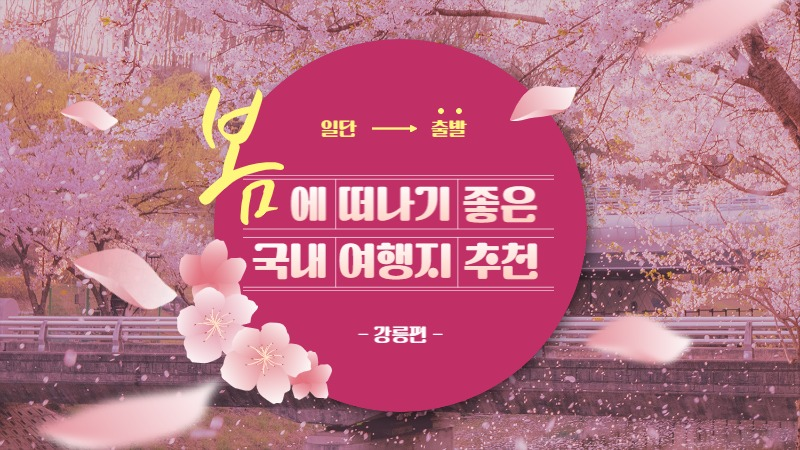

## This is candidate image
- The model returned 1 response(s):
{
  "배경색": "보라색",
  "꽃": "벚꽃",
  "글씨체": "하얀색",
  "내용": "비즈고회 - 너희 안에 이 마음을 품으라 곧 그리스도 예수의 마음이니 - 빌립보서 2:5 - 매주 주일 AM 11시"
}


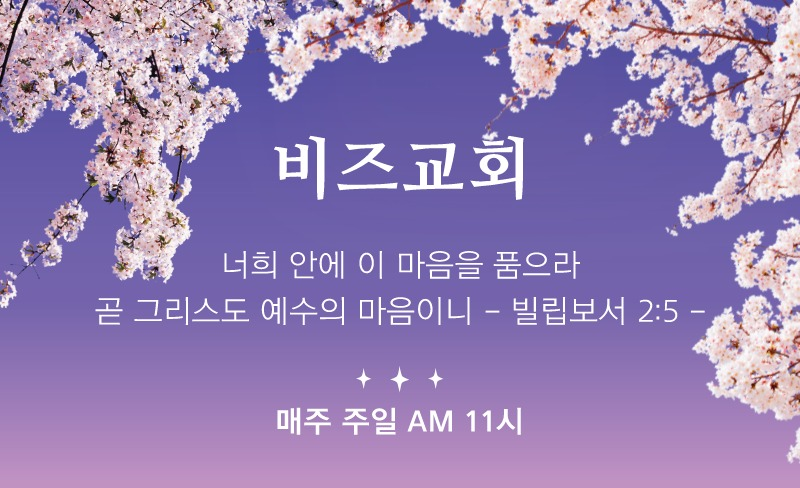

## This is candidate image
- The model returned 1 response(s):
{
  "배경": "분홍색 배경에 흰색 벚꽃 가지가 있습니다.",
  "제목": "봄을 맞아 세일해봄",
  "기간": "03.01-03.25",
  "할인": "미리미쳐에서 봄꽃축제 미리 준비하자 인기품목 최대 20%-50% 신세일",
  "매장정보": {
    "이름": "미리마켓",
    "주소": "서울시 구로구 디지털로 33길 43",
    "전화번호": "02 123 4567",
    "영업시간": "OPEN 9:00 - CLOSE 18:00"
  }
}


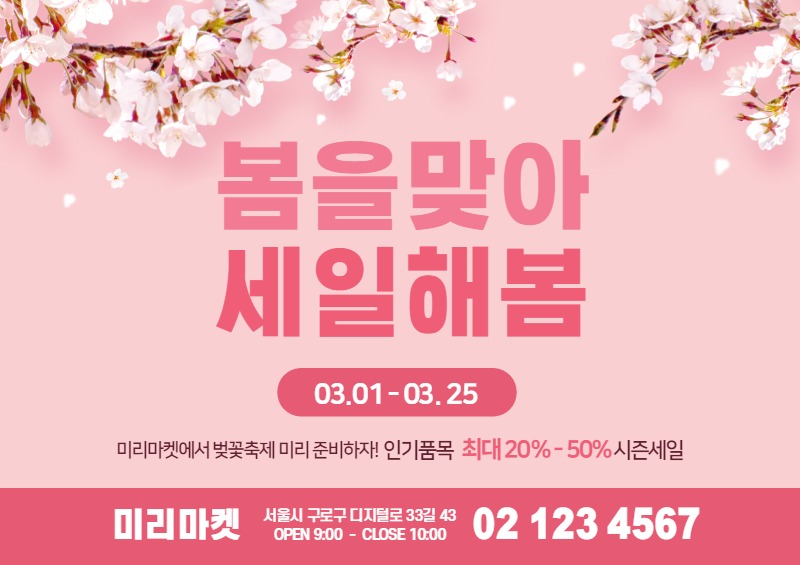

## This is candidate image
- The model returned 1 response(s):
{
  "배경색": "분홍색",
  "꽃": [
    {
      "종류": "벚꽃",
      "색상": "흰색, 분홍색"
    }
  ],
  "텍스트": [
    {
      "내용": "사랑과 감사를 담은 봄 꽃 템플릿",
      "설명": "봄 시즌을 알리는 벚꽃 이미지와 텍스트로 구성된 템플릿"
    },
    {
      "내용": "MFI COMPANY",
      "설명": "회사 또는 브랜드 이름"
    }
  ],
  "설명": "봄 시즌을 상징하는 벚꽃 이미지와 텍스트가 있는 분홍색 배경의 템플릿 이미지"
}


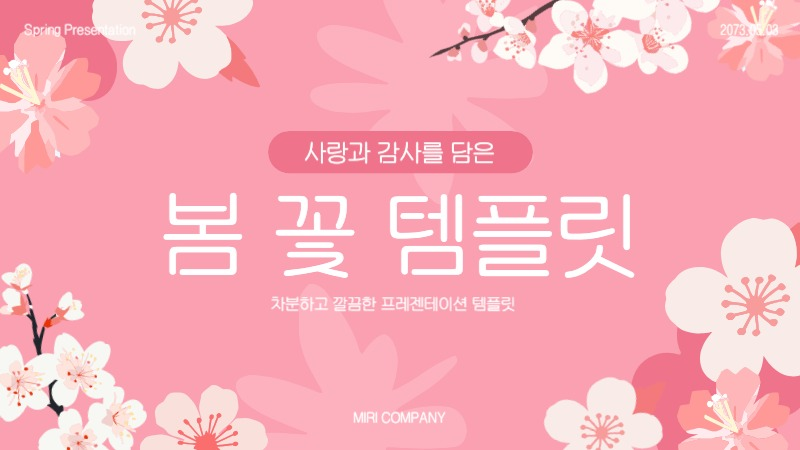

## This is candidate image
- The model returned 1 response(s):
{
  "설명": "이미지는 푸른 하늘을 배경으로 하얗게 피어난 벚꽃 나무 가지들을 보여주고 있습니다. 가지 끝에 아름답게 피어난 벚꽃들이 봄의 정취를 물씬 느끼게 합니다.",
  "속성": {
    "제목": "밀리카페",
    "내용": "때가 되면 꽃을 볼 수 있는 유쾌한 커피를 한잔 하실 수 있습니다.",
    "계절": "봄",
    "분위기": "평화로운, 싱그러운"
  }
}


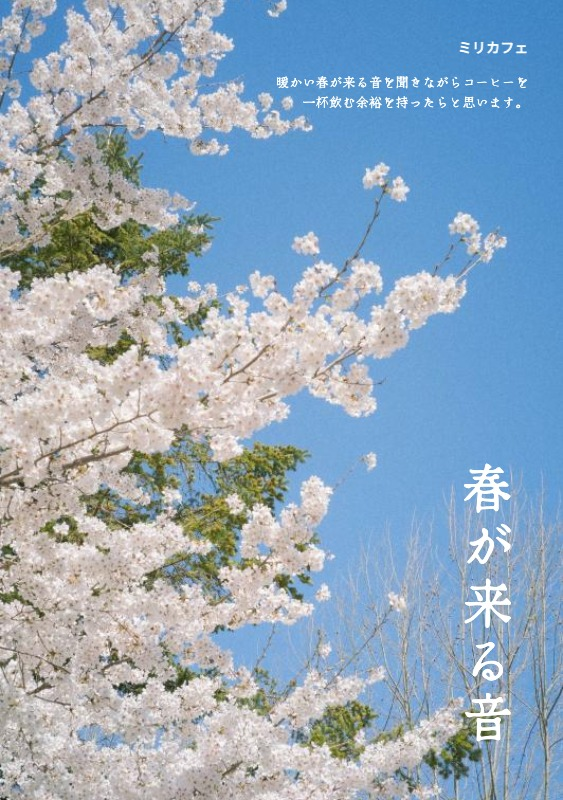

In [8]:
# invoke bedrock
# simple prompt

multimodal_text_prompt = "Extract the properties and description of this image as JSON in Korean."

target, associates = extract_properties_from_image(all_items,client,claude3_model_id,multimodal_text_prompt)                

## This is target image
../samples/sample_03/target_image.jpeg


- The model returned 1 response(s):
{
  "주요 시각 요소": [
    {
      "요소": "배경 이미지",
      "설명": "벚꽃 나무가 있는 공원 산책로의 아름다운 봄 풍경입니다. 분홍색 벚꽃이 만발하고 있으며 나무 아래로는 길이 나 있습니다."
    },
    {
      "요소": "텍스트",
      "설명": "중앙에 큰 원형 모양의 텍스트 박스가 있습니다. 진한 와인색 배경에 노란색과 흰색 텍스트가 대비를 이루고 있습니다. 메시지는 '봄에 떠나기 좋은 국내 여행지 추천'입니다."
    },
    {
      "요소": "화살표",
      "설명": "원형 텍스트 박스 위쪽에 작은 노란색 화살표가 있어 '왼쪽에서 오른쪽'으로 방향을 가리키고 있습니다."
    }
  ],

  "감정적 영향": "이 이미지는 봄의 활기찬 분위기와 여행의 설렘을 전달합니다. 벚꽃 풍경은 평화로움과 새로운 시작을 상징하며, 텍스트는 여행에 대한 기대감을 불러일으킵니다.",

  "문화적 의미": "한국에서 벚꽃 구경은 오랜 전통이 있는 봄 축제입니다. 이 이미지는 한국의 대표적인 봄 풍경과 여행 문화를 보여줍니다.",

  "기술적 세부사항": {
    "파일 형식": "JPG 또는 PNG",
    "해상도": "고해상도 권장",
    "색상 모드": "RGB"
  },

  "접근성 기능": [
    {
      "기능": "대체 텍스트",
      "설명": "시각 장애인을 위해 이미지의 주요 내용을 설명하는 대체 텍스트가 필요합니다."
    },
    {
      "기능": "충분한 대비",
      "설명": "텍스트와 배경 간의 색상 대비가 높아 가독성이 좋습니다."
    }
  ],

  "잠재적 용도": [
    "여행 웹사이트 또는 앱의 배너 이미지",
    "관광 안내 책자 표지",
    "봄 시즌 프로모션 광고",
    "소셜 미디어 게시물"
  ]
}


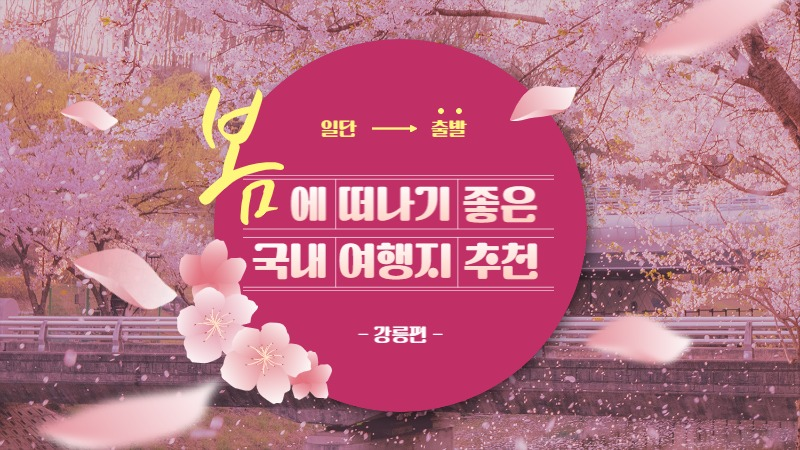

## This is candidate image
- The model returned 1 response(s):
{
  "키_시각_요소": [
    {
      "요소": "벚꽃 이미지",
      "설명": "이미지의 상단과 하단에는 만개한 벚꽃 가지가 있어 봄의 분위기를 자아냅니다."
    },
    {
      "요소": "보라색 배경",
      "설명": "부드러운 보라색 배경이 벚꽃과 대비를 이루며 고급스러운 느낌을 줍니다."
    },
    {
      "요소": "텍스트",
      "설명": "가운데에 '비즈교회', '너희 안에 이 마음을 품으라', '골 그리스도 예수의 마음이니', '빌립보서 2:5' 등의 텍스트가 있어 교회 행사를 알립니다."
    }
  ],
  "속성": [
    {
      "속성": "계절감",
      "설명": "만개한 벚꽃은 봄의 상징으로 새로운 시작과 희망의 메시지를 전달합니다."
    },
    {
      "속성": "고급스러움",
      "설명": "보라색 배경과 벚꽃의 조화로 고급스럽고 우아한 분위기를 자아냅니다."
    },
    {
      "속성": "종교성",
      "설명": "성경 구절과 교회 행사 안내로 기독교 정신을 드러냅니다."
    }
  ],
  "감정적_영향": [
    {
      "영향": "평화로움",
      "설명": "부드러운 색상과 자연 이미지가 주는 안정감으로 평화로운 기분을 느끼게 합니다."
    },
    {
      "영향": "희망",
      "설명": "봄의 상징인 벚꽃은 새로운 시작과 희망의 메시지를 전달합니다."
    },
    {
      "영향": "영적 고양",
      "설명": "종교적 메시지가 영적인 면에서 고양된 기분을 느끼게 합니다."
    }
  ],
  "문화적_의미": [
    {
      "의미": "봄 축제",
      "설명": "한국에서 벚꽃은 봄의 상징으

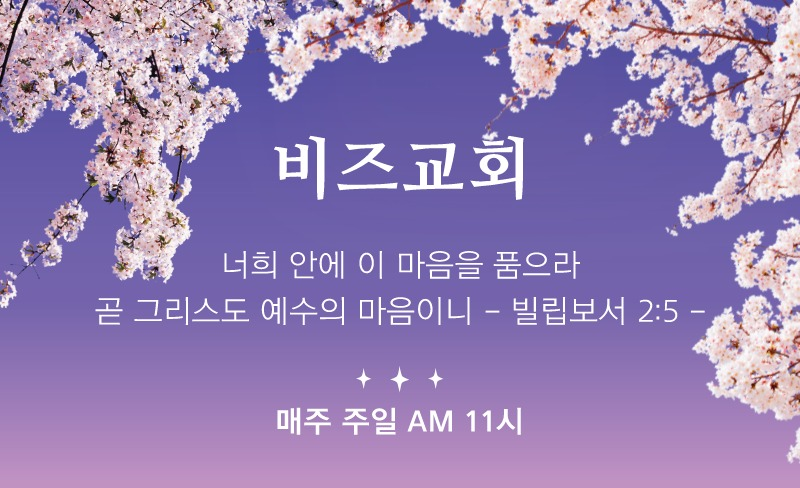

## This is candidate image
- The model returned 1 response(s):
{
  "주요시각요소": [
    {
      "요소": "벚꽃 이미지",
      "설명": "이미지 상단에는 분홍색 벚꽃 가지와 꽃잎이 흩날리는 모습이 있어 봄의 분위기를 자아냅니다."
    },
    {
      "요소": "텍스트",
      "설명": "중앙에 '클릴맑아 새일해봄'이라는 큰 텍스트가 있어 이벤트나 프로모션을 알리는 듯합니다. 아래에는 기간과 할인 정보가 작은 텍스트로 제공됩니다."
    },
    {
      "요소": "브랜드 로고 및 연락처",
      "설명": "하단에는 '미리마켓'이라는 브랜드 로고와 주소, 전화번호가 있어 매장 정보를 제공합니다."
    }
  ],
  "색상": [
    {
      "색상": "분홍색",
      "설명": "전체적으로 부드럽고 밝은 분홍색 계열의 색상이 사용되어 봄의 따뜻하고 화사한 분위기를 자아냅니다."
    }
  ],
  "서체": [
    {
      "서체": "고딕체",
      "설명": "텍스트에 고딕체 서체가 사용되어 있어 단순하고 모던한 느낌을 줍니다."
    }
  ],
  "감정적영향": "이미지는 봄의 화사함과 새로운 시작을 상징하는 벚꽃과 분홍색을 활용하여 따뜻하고 밝은 분위기를 자아내며, 행복하고 기분 좋은 감정을 불러일으킵니다.",
  "문화적의미": "한국에서 벚꽃은 봄의 시작을 알리는 대표적인 자연 이미지로, 새로운 시작과 희망을 상징합니다. 이는 한국 문화에서 중요한 의미를 지닙니다.",
  "기술적세부사항": {
    "파일형식": "JPG 또는 PNG",
    "해상도": "고해상도 권장",
    "투명도": "배경 투명도 지원 가능"
  },
  "접근성기능": [
    {
      "기능": "대체텍스트",
      "설명": "시각장애인을 위해 이미지에 대한 설명이 제공되어야 합니다."
 

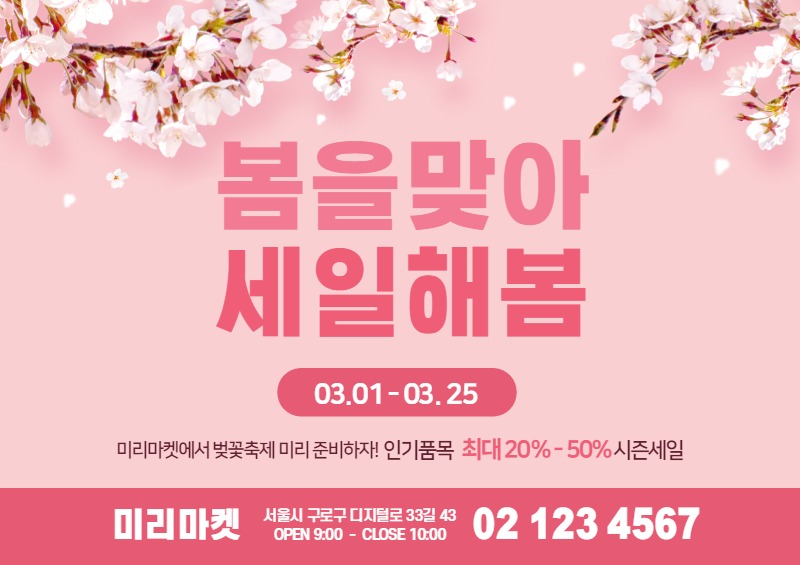

## This is candidate image
- The model returned 1 response(s):
{
  "시각적 요소": {
    "배경색": "밝고 부드러운 핑크색",
    "꽃 이미지": "흰색과 분홍색 벚꽃 모티브",
    "타이포그래피": "둥근 서체로 된 한글 텍스트 '봄 꽃 데플릿'"
  },
  "속성": {
    "계절감": "봄의 화사하고 생동감 있는 분위기",
    "여성스러움": "부드럽고 낭만적인 이미지",
    "전통미": "한국 전통 문화의 벚꽃 모티브 활용"
  },
  "감정적 영향": {
    "기쁨": "봄의 시작을 알리는 벚꽃으로 행복하고 밝은 느낌",
    "평화로움": "부드러운 색상과 자연 이미지로 편안함 제공",
    "낭만적": "꽃과 핑크색으로 사랑스럽고 로맨틱한 분위기 연출"
  },
  "문화적 의미": {
    "한국 전통": "벚꽃은 한국 문화에서 봄의 상징으로 중요한 의미",
    "자연 경외": "자연의 아름다움과 생명력에 대한 존중심 표현"
  },
  "기술적 세부사항": {
    "파일 형식": "PNG 또는 JPG 등의 래스터 이미지",
    "해상도": "고해상도로 다양한 미디어에 활용 가능"
  },
  "접근성 기능": {
    "대체 텍스트": "시각 장애인을 위한 이미지 설명 제공 필요",
    "색상 대비": "충분한 색상 대비로 가독성 확보"
  },
  "활용 분야": {
    "웹/모바일": "봄 시즌 프로모션, 이벤트 배너, 아이콘 등",
    "인쇄물": "카탈로그, 브로셔, 포스터 등의 시각 자료",
    "브랜딩": "봄 콘셉트의 제품 또는 서비스 브랜딩에 활용"
  }
}


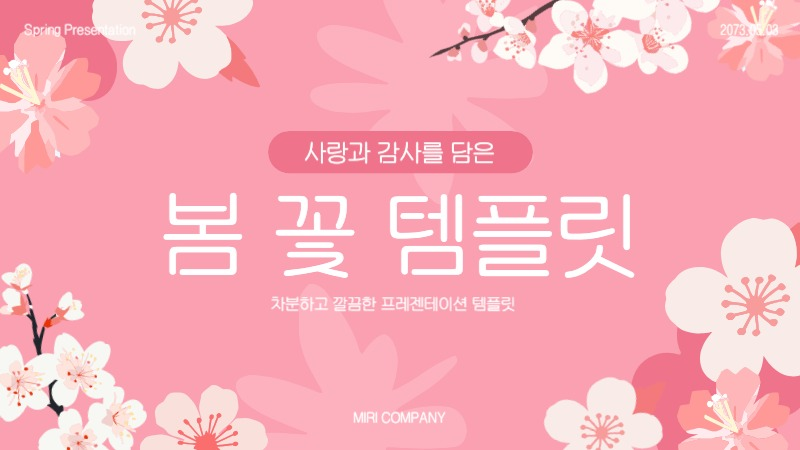

## This is candidate image
- The model returned 1 response(s):
{
  "이미지_분석": {
    "주요_시각_요소": [
      "벚꽃 나무 가지들",
      "흰색 꽃잎들",
      "푸른 하늘",
      "초록색 잎사귀들"
    ],
    "속성": {
      "색상": ["흰색", "파란색", "초록색"],
      "구도": "하늘을 향해 뻗어 있는 벚꽃 가지들",
      "조명": "자연광"
    },
    "감정적_영향": "봄의 싱그러움과 희망, 평화로움을 전달",
    "문화적_의미": "일본의 벚꽃 축제와 연관된 상징적 이미지, 계절의 변화와 자연의 아름다움을 대표",
    "기술_세부사항": {
      "해상도": "고해상도 이미지",
      "파일_형식": "JPG 또는 PNG 추정"
    },
    "접근성_기능": "높은 대비와 선명한 이미지로 시각 장애인도 인식 가능",
    "잠재적_용도": [
      "웹사이트 및 모바일 앱의 배경 이미지",
      "봄 시즌 프로모션 및 마케팅 자료",
      "벚꽃 축제 또는 관광 안내 자료",
      "벽지 또는 인테리어 디자인 소재"
    ]
  }
}


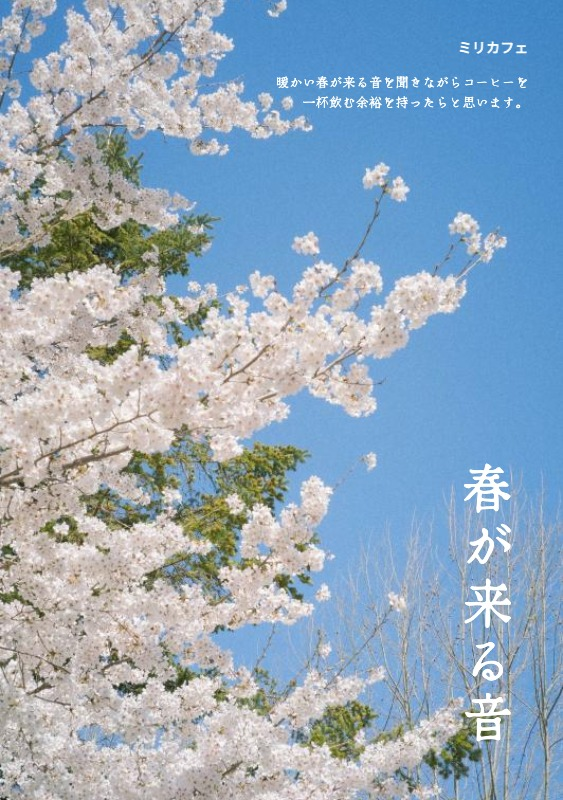

In [9]:
# invoke bedrock
# advance prompt
multimodal_text_prompt = "As a web designer, closely examine the given target image, \
    identify its key visual elements, attributes, emotional impact, cultural significance, technical details, accessibility features, \
        and potential applications across various platforms and media, \
            providing a comprehensive analysis in a structured JSON format and in Korean, \
                with detailed descriptions for each identified aspect to inform the effective integration and presentation of the image."


target, associates = extract_properties_from_image(all_items,client,claude3_model_id,multimodal_text_prompt)                

# 3. 어울리는 요소 선택 및 이유 설명

## 프롬프트 작성

In [31]:
image_expert_prompt = f"""You are a graphic designer. Given a specific image template and a collection of similar image templates in <associate_element>, \
    find the template that is most visually similar to the <target_image>. \
        Provide a detailed explanation for your choice, considering factors such as the similarity of composition, \
            color palette, style, subject matter, overall visual elements, and the subject matter of the image templates. \
                Your response should clearly demonstrate how the selected template aligns most closely with the provided template \
                    in terms of aesthetic and design principles, as well as the similarity of the subject matter."

Instructions:
1. Please respond in structed JSON format in Korean and without <output> tag.
2. Refer to the structure as below in <output_example>, but exclude the <output_example> tags themselves.    
3. Write "selected_image" in the form of summary simple as possible
4. Write "selected_image_path" given your selection from the <associate_element> list

<target_image>
{str(target)}
</target_image> 

<associate_image>
{str(associates)}
</associate_image>

<output_example>
"selected_image_path" : "candidate_element.jpg"
"reason" :
</output_example>
"""

## Claude3 Sonnet 모델로 요소 선택 및 이유 설명

In [32]:
claude3_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
response = invoke_claude3_sonnet_model(client = client, claude3_model_id = claude3_model_id,
                            prompt = image_expert_prompt, image = None, multimodal=False)

- The model returned 1 response(s):
{
  "selected_image_path": "../samples/sample_03/candidate_image_2.jpg",
  "reason": "이 이미지는 대상 이미지와 가장 유사한 시각적 요소와 주제를 가지고 있습니다. 상단에 만개한 벚꽃 가지가 있어 봄의 분위기를 자아내며, 중앙의 큰 텍스트는 이벤트나 프로모션을 알리는 듯합니다. 또한 하단의 브랜드 로고와 연락처 정보가 있어 실제 상업적 용도로 활용될 수 있습니다. 전체적으로 부드럽고 밝은 분홍색 계열의 색상이 사용되어 대상 이미지와 유사한 따뜻하고 화사한 분위기를 연출합니다. 이러한 시각적 구성과 봄 여행 프로모션이라는 주제 면에서 가장 유사성이 높습니다."
}


Sonnet이 선택한 이유만을 변수에 넣고 보여주기

In [33]:
from eval_utils.util import print_ww
select_reason_sonnet =  parse_output_select_reason(response)    
print_ww(select_reason_sonnet)

이 이미지는 대상 이미지와 가장 유사한 시각적 요소와 주제를 가지고 있습니다. 상단에 만개한 벚꽃 가지가 있어 봄의 분위기를 자아내며, 중앙의 큰 텍스트는 이벤트나 프로모션을
알리는 듯합니다. 또한 하단의 브랜드 로고와 연락처 정보가 있어 실제 상업적 용도로 활용될 수 있습니다. 전체적으로 부드럽고 밝은 분홍색 계열의 색상이 사용되어 대상 이미지와
유사한 따뜻하고 화사한 분위기를 연출합니다. 이러한 시각적 구성과 봄 여행 프로모션이라는 주제 면에서 가장 유사성이 높습니다.


## Claude3 Haiku 모델로 이미지 선택 및 이유 설명

In [34]:
claude3_model_id = "anthropic.claude-3-haiku-20240307-v1:0"
response = invoke_claude3_sonnet_model(client = client, claude3_model_id = claude3_model_id,
                            prompt = image_expert_prompt, image = None, multimodal=False)

- The model returned 1 response(s):
{
  "selected_image": "candidate_image_2.jpg",
  "selected_image_path": "../samples/sample_03/candidate_image_2.jpg",
  "reason": "candidate_image_2.jpg가 <target_image>와 가장 유사한 것으로 판단됩니다. 두 이미지 모두 봄의 분위기를 잘 표현하고 있으며, 벚꽃 이미지와 밝은 색상 사용, 텍스트 레이아웃 등 전반적인 시각적 구성이 유사합니다. 특히 <target_image>의 벚꽃 풍경과 중앙의 텍스트 박스, 화살표 등의 요소가 candidate_image_2.jpg에서도 유사하게 나타나고 있습니다. 또한 두 이미지 모두 봄 시즌 프로모션이나 이벤트를 알리는 용도로 활용될 수 있어 주제와 활용 분야에서도 일치합니다. 따라서 candidate_image_2.jpg가 <target_image>와 가장 유사한 템플릿이라고 판단됩니다."
}


Haiku가 선택한 이유만을 변수에 넣고 보여주기

In [35]:
select_reason_haiku = parse_output_select_reason(response)    
print_ww(select_reason_haiku)

candidate_image_2.jpg가 <target_image>와 가장 유사한 것으로 판단됩니다. 두 이미지 모두 봄의 분위기를 잘 표현하고 있으며, 벚꽃 이미지와 밝은 색상
사용, 텍스트 레이아웃 등 전반적인 시각적 구성이 유사합니다. 특히 <target_image>의 벚꽃 풍경과 중앙의 텍스트 박스, 화살표 등의 요소가
candidate_image_2.jpg에서도 유사하게 나타나고 있습니다. 또한 두 이미지 모두 봄 시즌 프로모션이나 이벤트를 알리는 용도로 활용될 수 있어 주제와 활용 분야에서도
일치합니다. 따라서 candidate_image_2.jpg가 <target_image>와 가장 유사한 템플릿이라고 판단됩니다.


## Sonnet & Haiku 이유 비교

In [36]:
print("## Claude3 Sonnet")
print_ww(select_reason_sonnet)
print("\n## Claude3 Haiku")
print_ww(select_reason_haiku)

## Claude3 Sonnet
이 이미지는 대상 이미지와 가장 유사한 시각적 요소와 주제를 가지고 있습니다. 상단에 만개한 벚꽃 가지가 있어 봄의 분위기를 자아내며, 중앙의 큰 텍스트는 이벤트나 프로모션을
알리는 듯합니다. 또한 하단의 브랜드 로고와 연락처 정보가 있어 실제 상업적 용도로 활용될 수 있습니다. 전체적으로 부드럽고 밝은 분홍색 계열의 색상이 사용되어 대상 이미지와
유사한 따뜻하고 화사한 분위기를 연출합니다. 이러한 시각적 구성과 봄 여행 프로모션이라는 주제 면에서 가장 유사성이 높습니다.

## Claude3 Haiku
candidate_image_2.jpg가 <target_image>와 가장 유사한 것으로 판단됩니다. 두 이미지 모두 봄의 분위기를 잘 표현하고 있으며, 벚꽃 이미지와 밝은 색상
사용, 텍스트 레이아웃 등 전반적인 시각적 구성이 유사합니다. 특히 <target_image>의 벚꽃 풍경과 중앙의 텍스트 박스, 화살표 등의 요소가
candidate_image_2.jpg에서도 유사하게 나타나고 있습니다. 또한 두 이미지 모두 봄 시즌 프로모션이나 이벤트를 알리는 용도로 활용될 수 있어 주제와 활용 분야에서도
일치합니다. 따라서 candidate_image_2.jpg가 <target_image>와 가장 유사한 템플릿이라고 판단됩니다.


In [37]:
%store select_reason_sonnet
%store select_reason_haiku

Stored 'select_reason_sonnet' (str)
Stored 'select_reason_haiku' (str)


# 다음 노트북을 실행 하세요
- [06_recommendation_reason_evaluation.ipynb](06_recommendation_reason_evaluation.ipynb)